***
# PREVISÃO DE VENDAS - REDE DE DROGARIAS 
***

## CONTEXTUALIZAÇÃO DO PROJETO:
***

O CFO da rede de drogarias solicitou uma previsão de vendas com o objetivo de obter informações precisas sobre o desempenho das lojas da rede e determinar o valor do investimento necessário para reformar cada uma das lojas. Utilizaremos um conjunto de dados históricos de vendas diárias que abrangem um período de dois anos e meio para fazer previsões de vendas diárias para as 1.115 lojas da rede localizadas em diferentes partes da Alemanha para os próximos 42 dias. Essas previsões fornecerão informações sobre o valor total das vendas esperadas em cada loja, bem como como essas vendas serão distribuídas diariamente. O objetivo final é fornecer informações confiáveis que permitam que a empresa tome decisões informadas sobre o investimento em reformas nas lojas.

**Premissas do negócio:**
    
    1. Foram consideradas para a previsão apenas as lojas que possuem o valor de vendas superior a 0 na base de dados.

    2. Os dias em que as lojas estavam fechadas foram descartadas na realização da previsão.
   

*O contexto, pessoas e perguntas são completamente fictícios.* O dataset utilizado para o projeto está disponível no [Kaggle](https://www.kaggle.com/competitions/rossmann-store-sales/data).

**SUMÁRIO DA ANÁLISE**


**1. IMPORTS DE LIBRARIES E DATASET**

**2. DESCRIÇÃO DO DATASET**
    
**4. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)**
   
    Hipóteses sobre os problemas definidos analisando visualmente os dados.
    1. Quais são as variáveis que impactam o fenômeno que estamos modelando?
    2. O que faz a venda diminuir e aumentar? 
    3. Verificar forças das correlações
    
**3. DATA CLEANING**
        
    Verificar as inconsistências nos dados, lidar com valores ausentes e tratar os dados.

**5. FEATURE ENGINEERING**
    
    Seleção das features importantes e construção de outras features mais significativas usando os dados brutos.
    
**6. MACHINE LEARNING**
    
**7. CONCLUSÃO DO PROJETO E PERSPECTIVAS**


# LOADING LIBRARIES

In [548]:
import pandas as pd
import inflection
import math
import numpy as np
import datetime
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from dython.nominal import associations
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)
import sidetable as stb
from dython.nominal import associations

In [549]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [550]:
plt.rcParams['figure.figsize'] = [12, 5]

# FUNÇÕES AUXILIARES

# LOADING DATASET

In [551]:
# Dados históricos, incluindo a target vendas
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)

# Informações complementares sobre as lojas
df_store_raw = pd.read_csv('../data/raw/store.csv')

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')

# EXPLORAÇÃO DO DATASET 

In [552]:
print('Número de linhas:{}'.format(df_raw.shape[0]))
print('Número de colunas:{}'.format(df_raw.shape[1]))

Número de linhas:1017209
Número de colunas:18


In [553]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [554]:
df_raw.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.00,6.00,2014.00,1,31.00,2013.00,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.00,4.00,2006.00,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.00,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.00,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.00,NaN,NaN,1,22.00,2012.00,"Mar,Jun,Sept,Dec"


## Descrição das colunas do dataset

In [ ]:
df_raw.columns

 Variável | Descrição
:------------|:---------
Store | ID exclusivo para cada loja
Sales | O volume de vendas de um determinado dia (variável que será prevista)
Customers | Número de clientes em um determinado dia
Open | Indicador para funcionamento da loja, aberta: 0 = fechada e 1 = aberta
StateHoliday | Feriado estadual. Normalmente todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Todas as escolas estão fechadas nos feriados e fins de semana. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday | Indica se store e date foram afetadas pelo fechamento de escolas públicas
StoreType | Diferencia entre os 4 modelos de loja diferentes (a, b, c, d)
Assortment | Descreve um nível de sortimento (a = basic, b = extra, c = extended)
Competition_distance | Distância em metros até a loja concorrente mais próxima
Competition_open_since (_month/_year) | Fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto
Promo | Indica se uma loja está realizando uma promoção naquele dia (0 = store is not participating, 1 = store is participating)
Promo2 | Promo2 é uma promoção contínua e consecutiva para algumas lojas (0 = store is not participating, 1 = store is participating)
Promo2_since(_year/_week) | Descreve o ano e a semana do calendário em que a loja começou a participar da promo2
Promo_interval | Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. E.g: "Feb,May,Aug,Nov" significa que cada rodada começa em February, May, August, November de qualquer ano para essa loja.

## Análise da qualidade dos dados

In [555]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.00,558.43,321.91,1.00,280.00,558.00,838.00,1115.00
DayOfWeek,1017209.00,4.00,2.00,1.00,2.00,4.00,6.00,7.00
Sales,1017209.00,5773.82,3849.93,0.00,3727.00,5744.00,7856.00,41551.00
Customers,1017209.00,633.15,464.41,0.00,405.00,609.00,837.00,7388.00
Open,1017209.00,0.83,0.38,0.00,1.00,1.00,1.00,1.00
Promo,1017209.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
SchoolHoliday,1017209.00,0.18,0.38,0.00,0.00,0.00,0.00,1.00
CompetitionDistance,1014567.00,5430.09,7715.32,20.00,710.00,2330.00,6890.00,75860.00
CompetitionOpenSinceMonth,693861.00,7.22,3.21,1.00,4.00,8.00,10.00,12.00
CompetitionOpenSinceYear,693861.00,2008.69,5.99,1900.00,2006.00,2010.00,2013.00,2015.00


## Tipos de dados e conversão de tipo

In [556]:
df_raw.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [557]:
# Converter 'Date' para datetime
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

In [558]:
# Check
df_raw.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## Dados ausentes

In [559]:
df_raw.stb.missing()

,missing,total,percent
PromoInterval,508031,1017209,49.94
Promo2SinceYear,508031,1017209,49.94
Promo2SinceWeek,508031,1017209,49.94
CompetitionOpenSinceYear,323348,1017209,31.79
CompetitionOpenSinceMonth,323348,1017209,31.79
CompetitionDistance,2642,1017209,0.26
DayOfWeek,0,1017209,0.00
Promo2,0,1017209,0.00
Assortment,0,1017209,0.00
Store,0,1017209,0.00


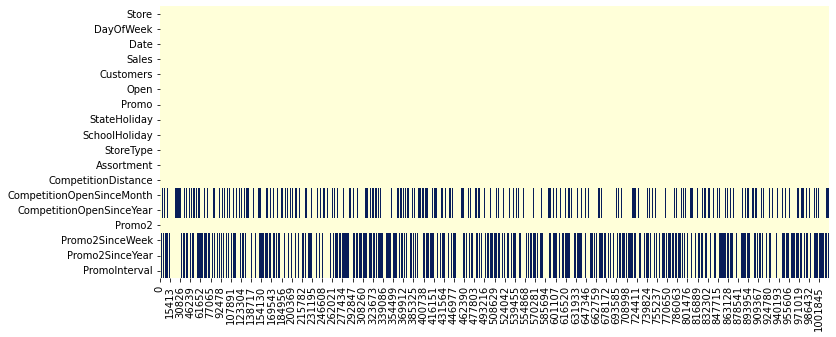

In [560]:
# Visualizando a distribuição dos missing values
sns.heatmap(df_raw.isnull().transpose(), cmap='YlGnBu', cbar=False);

In [561]:
len(df_raw.query('Promo2 == 0'))

508031

**O gráfico mostra visualmente que:**

- As colunas relacionadas a CompetitionOpenSinceMonth e CompetitionOpenSinceYear têm mais de 30% de valores ausentes.  
- A quantidade de valores ausentes foi muito alta para 'Promo2SinceWeek', 'Promo2SinceYear' e 'PromoInterval', o impacto de excluí-la pode ser pequeno
- 508031 lojas não participaram da Promo2 e são as mesmas lojas com valores ausentes para as três variáveis. Portanto, considero que uma estratégia de preenchimento não seja adequada para as features relacionadas a promoção extendida (Promo2).

### Removendo as colunas 'Promo2SinceWeek', 'Promo2SinceYear' e 'PromoInterval'

In [562]:
# Cópia dos dados brutos
df1 = df_raw.copy()

In [563]:
df1 = df1.drop(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

## Novas variáveis a partir da feature 'Date'

In [564]:
# Year
df1['Year'] = df1['Date'].dt.year

# Month
df1['Month'] = df1['Date'].dt.month

# Day
df1['Day'] = df1['Date'].dt.day

# Week of year
df1['WeekOfYear'] = df1['Date'].dt.isocalendar().week

# Year Week
df1['YearWeek'] = df1['Date'].dt.strftime('%Y-%W')

# Dicionário com as estações do ano na Alemanha
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 
           6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}

# Criação da coluna 'Season' com base na coluna 'Month'
df1['Season'] = df1['Month'].map(seasons)

In [565]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Year,Month,Day,WeekOfYear,YearWeek,Season
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.00,9.00,2008.00,0,2015,7,31,31,2015-30,Summer
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.00,11.00,2007.00,1,2015,7,31,31,2015-30,Summer
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.00,12.00,2006.00,1,2015,7,31,31,2015-30,Summer
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.00,9.00,2009.00,0,2015,7,31,31,2015-30,Summer
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.00,4.00,2015.00,0,2015,7,31,31,2015-30,Summer


## Filtragem dos dados

A partir da análise da tabela com a descrição das variáveis, podemos observar que 
existem valores registrados como 0 para **Sales**, **Customers** e **Open**.

    1 - Quantas lojas estão fechadas?
    2 - Quantas lojas apresentaram valor de Sales = 0?
    3 - Quantas lojas apresentaram valor de Customers = 0?

In [566]:
store_closed = len(df1.query('Open == 0'))                             
print(f"1. Temos {store_closed} lojas fechadas.")

sales_0 = len(df1.query('Sales == 0'))
print(f"2. Temos {sales_0} lojas com vendas registradas como 0.")

customers_0 = len(df1.query('Customers == 0'))
print(f"3. Temos {customers_0} lojas com 0 clientes.")

1. Temos 172817 lojas fechadas.
2. Temos 172871 lojas com vendas registradas como 0.
3. Temos 172869 lojas com 0 clientes.


In [567]:
df1[['Open', 'StateHoliday', 'SchoolHoliday', 'Sales', 'Customers']
    ].groupby(['Open', 'StateHoliday', 'SchoolHoliday']).agg({'Sales': ['mean'], 'Customers': ['mean']}).stb.flatten()

,Open,StateHoliday,SchoolHoliday,Sales_mean,Customers_mean
0,0,0,0,0.00,0.00
1,0,0,1,0.00,0.00
2,0,a,0,0.00,0.00
3,0,a,1,0.00,0.00
4,0,b,0,0.00,0.00
5,0,b,1,0.00,0.00
6,0,c,1,0.00,0.00
7,1,0,0,6895.15,757.35
8,1,0,1,7196.90,781.77
9,1,a,0,8492.07,1266.11


In [568]:
df1[['Open', 'StoreType', 'Assortment', 'Sales', 'Customers']
    ].groupby(['Open', 'StoreType', 'Assortment']).agg({'Sales': ['mean'], 'Customers': ['mean']}).stb.flatten()

,Open,StoreType,Assortment,Sales_mean,Customers_mean
0,0,a,a,0.00,0.00
1,0,a,c,0.00,0.00
2,0,b,a,0.00,0.00
3,0,b,b,0.00,0.00
4,0,c,a,0.00,0.00
5,0,c,c,0.00,0.00
6,0,d,a,0.00,0.00
7,0,d,c,0.00,0.00
8,1,a,a,6537.62,759.24
9,1,a,c,7573.38,855.77


**Como premissa não consideraremos os dias com as lojas fechadas, ou seja, 'Open' == 0.**

In [569]:
df2 = df1.copy()

In [570]:
# Filtragem
df2 = df2.loc[(df2['Open'] != 0)]

In [571]:
print('Número de linhas:{}'.format(df2.shape[0]))
print('Número de colunas:{}'.format(df2.shape[1]))

Número de linhas:844392
Número de colunas:21


In [572]:
df2.stb.missing()

,missing,total,percent
CompetitionOpenSinceYear,268619,844392,31.81
CompetitionOpenSinceMonth,268619,844392,31.81
CompetitionDistance,2186,844392,0.26
Store,0,844392,0.00
YearWeek,0,844392,0.00
WeekOfYear,0,844392,0.00
Day,0,844392,0.00
Month,0,844392,0.00
Year,0,844392,0.00
Promo2,0,844392,0.00


# ANÁLISE EXPLORATÓRIA DE DADOS

    Diversos fatores podem influenciar o desempenho das vendas de uma rede de drogarias em lojas físicas. 
    Como as expostas na imagem abaixo:

![Map hipoteses](../img/mind_map.jpg "Mapa Mental")

**HIPÓTESES**

**Clientes**

    a. As vendas podem ser diferentes dependendo do perfil dos clientes, como a faixa etária ou o 
    nível socioeconômico.
    b. Um maior número de clientes em uma determinada loja ou período resulta em mais vendas.
    
**Produtos**

    a. As vendas podem aumentar durante campanhas de marketing e promoções, como liquidações de estoque 
    ou descontos em compras.
    b. Um maior sortimento de produtos pode atrair diferentes tipos de clientes e aumentar a probabilidade
    de encontrar produtos que atendam às necessidades dos clientes. Em consequência, isso pode levar a um 
    aumento nas vendas.

**Localização da loja**

    a. As vendas podem ser afetadas pela presença de concorrentes nas proximidades ou pela abertura de novas
    lojas na região.
    b. As vendas podem variar dependendo da localização das lojas, como em áreas urbanas com alta densidade 
    populacional ou em bairros residenciais.
    
**Temporalidade**
    
    a. Dia da semana: as vendas podem ser maiores em certos dias da semana, como sexta-feira ou sábado, devido ao 
    aumento do tráfego de compradores nos finais de semana.
    b. Estação do ano: as vendas podem ser influenciadas por mudanças sazonais, como o aumento das vendas 
    de protetor solar no verão ou de vitaminas e remédios no inverno.
    c. Feriados também podem influenciar as vendas, com um aumento esperado nas vendas durante feriados 
    como Natal.

## Estatística descritiva

In [573]:
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Features numéricas

In [574]:
# Medidas de tendência central e dispersão
num_attributes.agg(['mean', 'median', 'std', 'min', 'max', 'ptp', 'skew',
                   'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

,Attributes,mean,median,std,min,max,range,skew,kurtosis
0,Store,558.42,558.00,321.73,1.00,1115.00,1114.00,0.00,-1.20
1,DayOfWeek,3.52,3.00,1.72,1.00,7.00,6.00,0.02,-1.26
2,Sales,6955.51,6369.00,3104.21,0.00,41551.00,41551.00,1.59,4.85
3,Customers,762.73,676.00,401.23,0.00,7388.00,7388.00,2.79,13.31
4,Open,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00
5,Promo,0.45,0.00,0.50,0.00,1.00,1.00,0.22,-1.95
6,SchoolHoliday,0.19,0.00,0.40,0.00,1.00,1.00,1.55,0.41
7,CompetitionDistance,5457.98,2320.00,7809.44,20.00,75860.00,NaN,2.98,13.41
8,CompetitionOpenSinceMonth,7.22,8.00,3.21,1.00,12.00,NaN,-0.17,-1.25
9,CompetitionOpenSinceYear,2008.70,2010.00,5.98,1900.00,2015.00,NaN,-7.52,121.85


#### Histograma das variáveis numéricas: Vendas, Número de Clientes e Distância do Concorrente

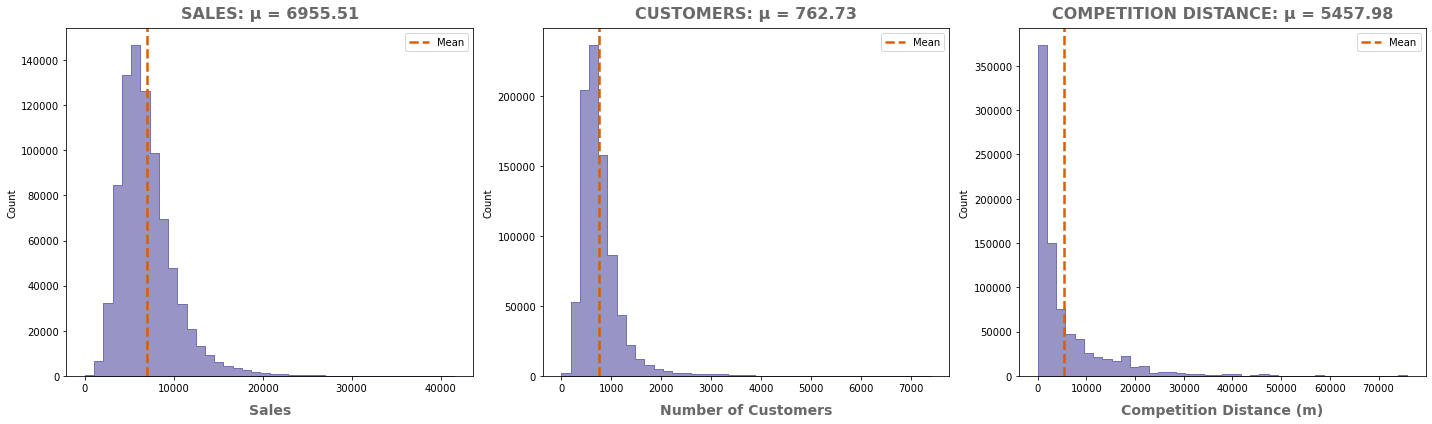

In [575]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(20, 6))
# Sales
sns.histplot(num_attributes.Sales, bins=40, element='step',
             color='#7570b3', ax=ax0)
ax0.set_xlabel('Sales', labelpad=10, fontsize=14,
               color='dimgrey', fontweight='bold')
ax0.axvline(x=num_attributes.Sales.mean(),
            label='Mean', color='#d95f02', ls='--', lw=2.5)
ax0.set_title('SALES: μ = 6955.51', fontsize=16, pad=10,
              color='dimgrey', fontweight='bold')
ax0.legend()

# Customers
sns.histplot(num_attributes.Customers, bins=40, element='step',
             color='#7570b3', ax=ax1)
ax1.set_xlabel('Number of Customers', labelpad=10,
               fontsize=14, color='dimgrey', fontweight='bold')
ax1.axvline(x=num_attributes.Customers.mean(),
            label='Mean', color='#d95f02', ls='--', lw=2.5)
ax1.set_title('CUSTOMERS: μ = 762.73', fontsize=16,
              pad=10, color='dimgrey', fontweight='bold')
ax1.legend()

# Competition Distance
sns.histplot(num_attributes.CompetitionDistance, element='step',
             bins=40, color='#7570b3', ax=ax2)
ax2.set_xlabel('Competition Distance (m)', labelpad=10,
               fontsize=14, color='dimgrey', fontweight='bold')
ax2.axvline(x=num_attributes.CompetitionDistance.mean(),
            label='Mean', color='#d95f02', ls='--', lw=2.5)
ax2.set_title('COMPETITION DISTANCE: μ = 5457.98', fontsize=16,
              pad=10, color='dimgrey', fontweight='bold')
ax2.legend();

fig.tight_layout()

### Features categóricas

In [578]:
cat_attributes.head()

,StateHoliday,StoreType,Assortment,WeekOfYear,YearWeek,Season
0,0,c,a,31,2015-30,Summer
1,0,a,a,31,2015-30,Summer
2,0,a,a,31,2015-30,Summer
3,0,c,c,31,2015-30,Summer
4,0,a,a,31,2015-30,Summer


In [579]:
# Número de valores exclusivos para cada variável categórica
cat_attributes.nunique()

StateHoliday      4
StoreType         4
Assortment        3
WeekOfYear       52
YearWeek        137
Season            4
dtype: int64

In [ ]:
#holidays = df2[df2['StateHoliday'] != '0']

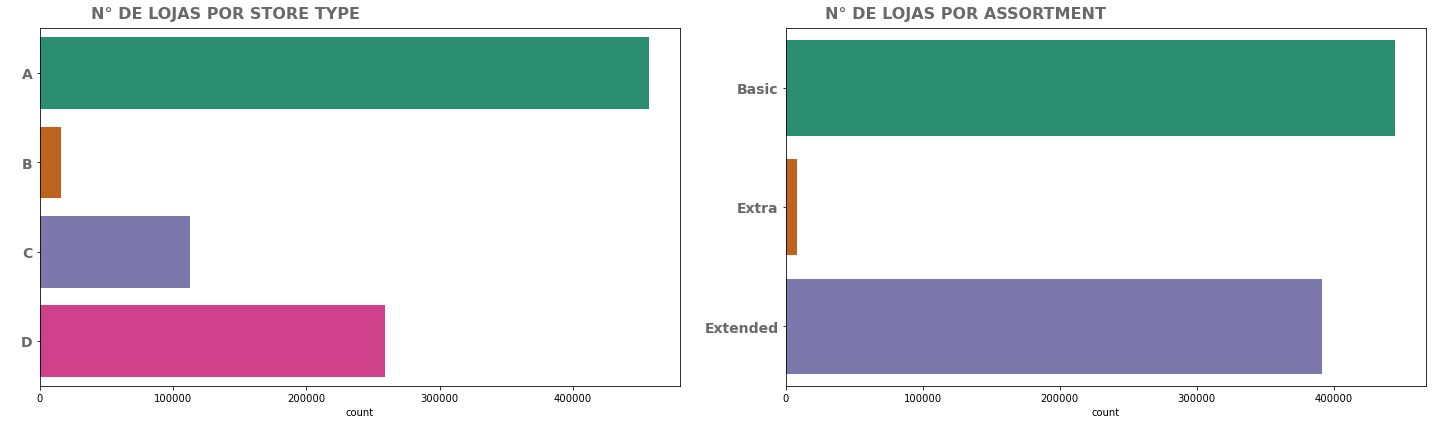

In [582]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

# Store Type
sns.countplot(y='StoreType', data=df2, palette='Dark2',
              order=['a', 'b', 'c', 'd'], ax=ax0)
ax0.set_yticklabels(['A', 'B', 'C', 'D'],
                    fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_ylabel(' ')
ax0.set_title('N° DE LOJAS POR STORE TYPE', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold', ha='right')

# Assortment
sns.countplot(y='Assortment', data=df2, palette='Dark2',
              order=['a', 'b', 'c'], ax=ax1)
ax1.set_yticklabels(['Basic', 'Extra', 'Extended'],
                    fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_ylabel(' ')
ax1.set_title('N° DE LOJAS POR ASSORTMENT', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold', ha='right')

fig.tight_layout()

In [589]:
# StoreType pode assumir os valores a, b, c ou d.
df2.stb.freq(['StoreType'])

,StoreType,count,percent,cumulative_count,cumulative_percent
0,a,457077,54.13,457077,54.13
1,d,258774,30.65,715851,84.78
2,c,112978,13.38,828829,98.16
3,b,15563,1.84,844392,100.00


In [587]:
# Assortment descreve um nível de sortimento da loja.
# a = basic, b = extra, c = extended
df2.stb.freq(['Assortment'])

,Assortment,count,percent,cumulative_count,cumulative_percent
0,a,444909,52.69,444909,52.69
1,c,391271,46.34,836180,99.03
2,b,8212,0.97,844392,100.00


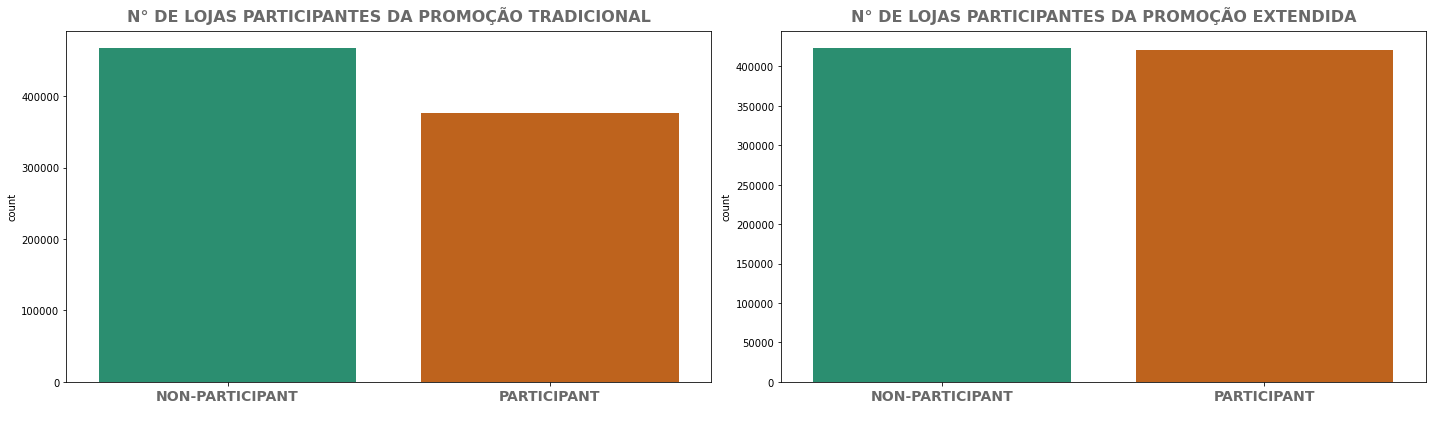

In [583]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

# Promo
sns.countplot(x='Promo', data=df2, palette='Dark2', ax=ax0)
ax0.set_xticklabels(['NON-PARTICIPANT', 'PARTICIPANT'],
                    fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_xlabel(' ')
ax0.set_title('N° DE LOJAS PARTICIPANTES DA PROMOÇÃO TRADICIONAL', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')

# Promo2
sns.countplot(x='Promo2', data=df2, palette='Dark2', ax=ax1)
ax1.set_xticklabels(['NON-PARTICIPANT', 'PARTICIPANT'],
                    fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_xlabel(' ')
ax1.set_title('N° DE LOJAS PARTICIPANTES DA PROMOÇÃO EXTENDIDA', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold');

fig.tight_layout()

In [590]:
# Promo
df2.stb.freq(['Promo'])

,Promo,count,percent,cumulative_count,cumulative_percent
0,0,467496,55.36,467496,55.36
1,1,376896,44.64,844392,100.00


In [591]:
# Promo
df2.stb.freq(['Promo2'])

,Promo2,count,percent,cumulative_count,cumulative_percent
0,0,423307,50.13,423307,50.13
1,1,421085,49.87,844392,100.00


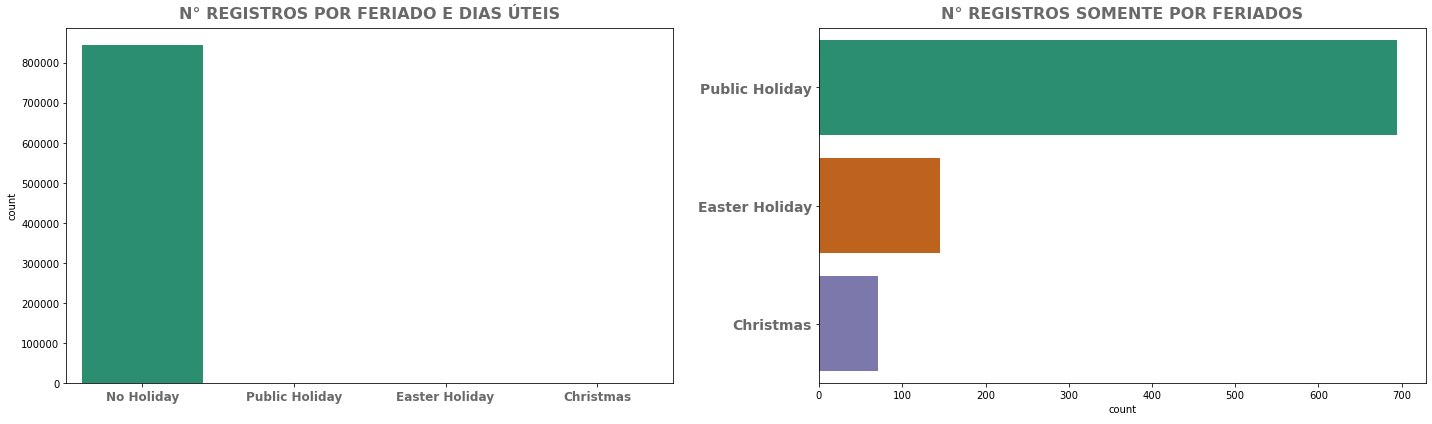

In [593]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))
# StateHoliday
sns.countplot(x='StateHoliday', data=df2, palette='Dark2', ax=ax0)
ax0.set_xticklabels(
    ['No Holiday','Public Holiday', 'Easter Holiday', 'Christmas'], fontsize=12, color='dimgrey', fontweight='bold')
ax0.set_xlabel(' ')
ax0.set_title('N° REGISTROS POR FERIADO E DIAS ÚTEIS', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')

# Excluindo os registros dos dias úteis
holidays = df2[df2['StateHoliday'] != '0']
sns.countplot(y='StateHoliday', data=holidays, palette='Dark2', ax=ax1)
ax1.set_yticklabels(
    ['Public Holiday', 'Easter Holiday', 'Christmas'], fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_ylabel(' ')
ax1.set_title('N° REGISTROS SOMENTE POR FERIADOS', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold');

fig.tight_layout()

In [594]:
# StateHoliday pode assumir os seguintes valores: 
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2.stb.freq(['StateHoliday'])

,StateHoliday,count,percent,cumulative_count,cumulative_percent
0,0,843482,99.89,843482,99.89
1,a,694,0.08,844176,99.97
2,b,145,0.02,844321,99.99
3,c,71,0.01,844392,100.00


In [595]:
# SchoolHoliday pode assumir os seguintes valores: 
# 0 ou 1
df2.stb.freq(['SchoolHoliday'])

,SchoolHoliday,count,percent,cumulative_count,cumulative_percent
0,0,680935,80.64,680935,80.64
1,1,163457,19.36,844392,100.00


## Hipótese sobre localização

### Lojas com competidores mais próximos vendem menos

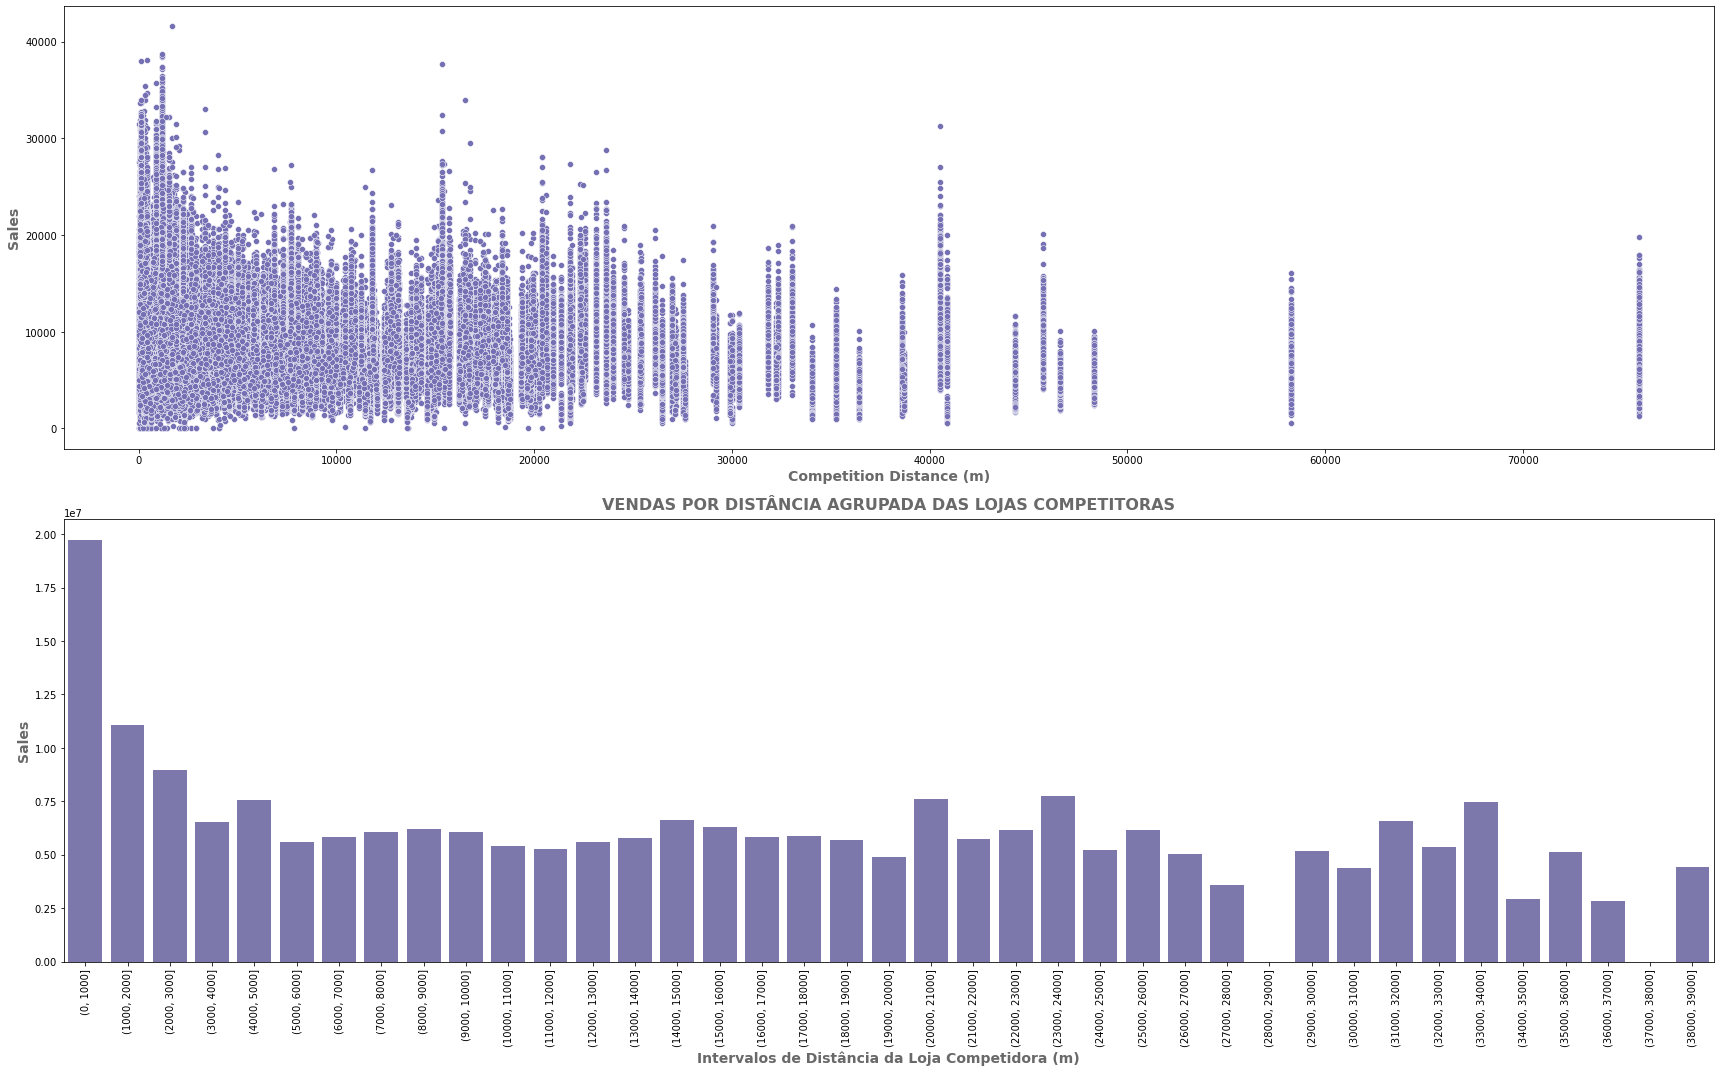

In [596]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
                               figsize=(24, 15))

# Gráfico de Distribuição de ponto para verificarmos a distribuição das vendas em relação a distancia do competidor
sns.scatterplot(x='CompetitionDistance', y='Sales',
                color='#7570b3', data=df2, ax=ax0)
ax0.set_xlabel('Competition Distance (m)', fontsize=14,
               color='dimgrey', fontweight='bold')
ax0.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')

# Criando agrupamentos para as distâncias
c_dist = df2[['CompetitionDistance', 'Sales']].groupby(
    'CompetitionDistance').sum().reset_index()
bins = list(np.arange(0, 40000, 1000))
c_dist['CompetitionDistanceBinned'] = pd.cut(
    c_dist['CompetitionDistance'], bins=bins)
c_dist_grouped = c_dist[['CompetitionDistanceBinned', 'Sales']].groupby(
    'CompetitionDistanceBinned').mean().reset_index()

# Plotando o gráfico de barras
sns.barplot(x='CompetitionDistanceBinned',
            y='Sales', data=c_dist_grouped, color='#7570b3', ax=ax1)
ax1.set_xlabel('Intervalos de Distância da Loja Competidora (m)',
               fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_title('VENDAS POR DISTÂNCIA AGRUPADA DAS LOJAS COMPETITORAS',
              pad=10, fontsize=16, color='dimgrey', fontweight='bold')
plt.xticks(rotation=90)

fig.tight_layout()

## Hipóteses sobre produto

### Lojas com maior sortimento apresentam maiores valores de venda.

   Um maior sortimento de produtos pode atrair diferentes tipos de clientes e aumentar a probabilidade de 
   encontrar produtos que atendam às necessidades dos clientes. Em consequência, isso pode levar a um  aumento 
   nas vendas.
   
   Em contrapartida, as lojas com sortimento b = extra ou c = extended não apresentaram um volume de vendas maior 
   quando comparadas as lojas de sortimento a = basic.

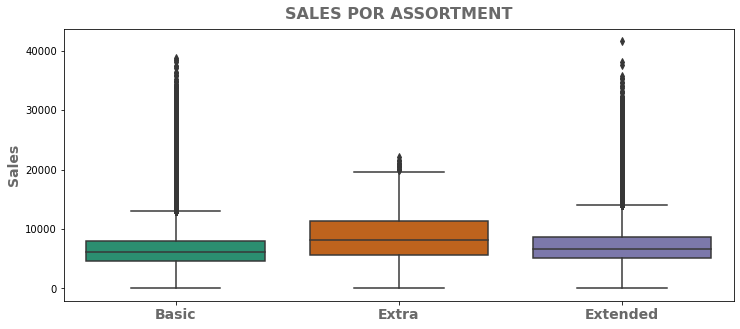

In [597]:
assort = sns.boxplot(x='Assortment', y='Sales', data=df2,
                     palette='Dark2', order=['a', 'b', 'c'])
assort.set_xticklabels(['Basic', 'Extra', 'Extended'],
                       fontsize=14, color='dimgrey', fontweight='bold')
assort.set_xlabel('')
assort.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
assort.set_title('SALES POR ASSORTMENT', pad=10,
                 fontsize=16, color='dimgrey', fontweight='bold');

**Há variação das vendas por sortimento ao longo dos anos?**

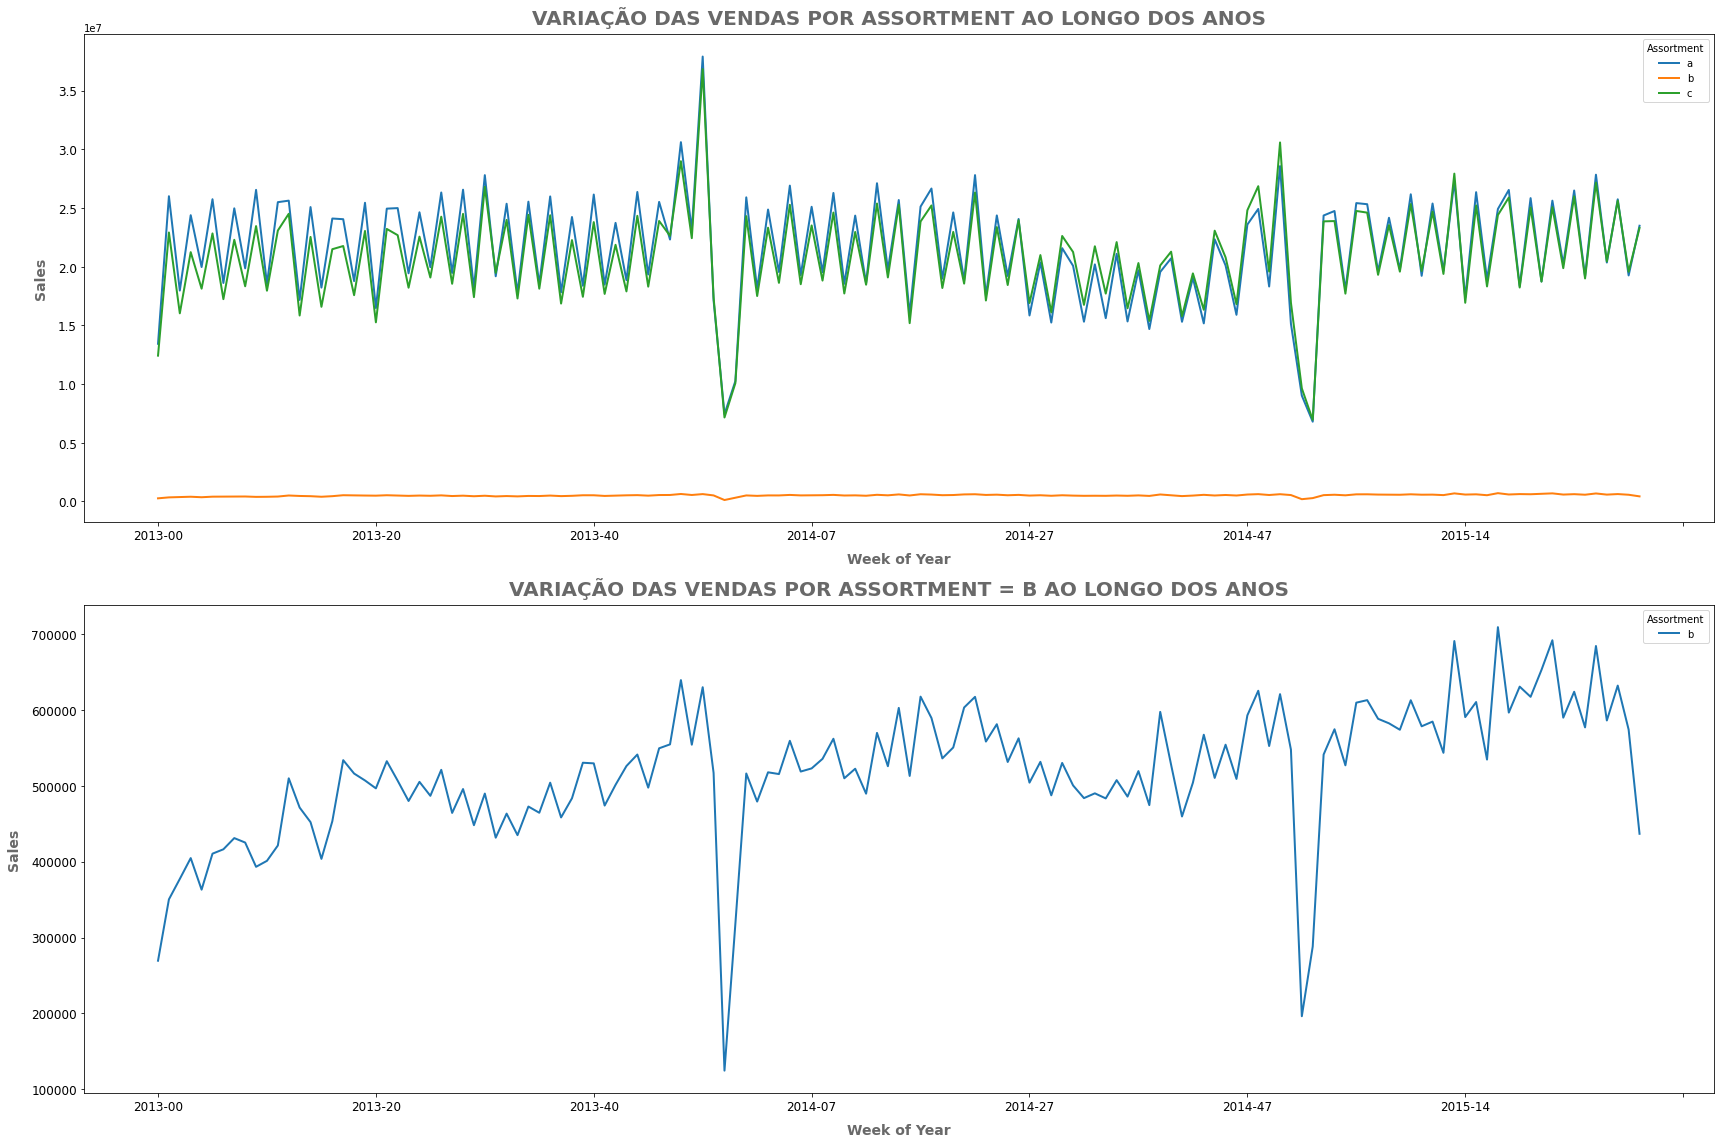

In [598]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
                               figsize=(24, 16))

# Agrupando os dados
sales_assort = df2[['YearWeek', 'Assortment', 'Sales']].groupby(
    ['YearWeek', 'Assortment']).sum().reset_index()

# Gráfico
aux.pivot(index='YearWeek', columns='Assortment',
          values='Sales').plot(fontsize=12, linewidth=2, ax=ax0)
ax0.set_xlabel('Week of Year', labelpad=10, fontsize=14,
               color='dimgrey', fontweight='bold')
ax0.set_ylabel('Sales', labelpad=10, fontsize=14,
               color='dimgrey', fontweight='bold')
ax0.set_title('VARIAÇÃO DAS VENDAS POR ASSORTMENT AO LONGO DOS ANOS',
              pad=10, fontsize=20, color='dimgrey', fontweight='bold')

# Filtrando as lojas com Assortment == a
assort_b = sales_assort[sales_assort['Assortment'] == 'b']
# Gráfico
assort_b.pivot(index='YearWeek', columns='Assortment',
               values='Sales').plot(fontsize=12, linewidth=2, ax=ax1)
ax1.set_xlabel('Week of Year', labelpad=10, fontsize=14,
               color='dimgrey', fontweight='bold')
ax1.set_ylabel('Sales', labelpad=10, fontsize=14,
               color='dimgrey', fontweight='bold')
ax1.set_title('VARIAÇÃO DAS VENDAS POR ASSORTMENT = B AO LONGO DOS ANOS',
              pad=10, fontsize=20, color='dimgrey', fontweight='bold');
fig.tight_layout()

### Lojas com promoções ativas por mais tempo vendem mais

As vendas podem aumentar durante campanhas de marketing e promoções, como liquidações de estoque 
ou descontos em compras.

In [599]:
df2[['Promo','Promo2','Sales']].groupby(['Promo', 'Promo2']).agg({'Sales': ['mean']}).stb.flatten()

,Promo,Promo2,Sales_mean
0,0,0,6327.97
1,0,1,5528.97
2,1,0,8618.13
3,1,1,7836.09


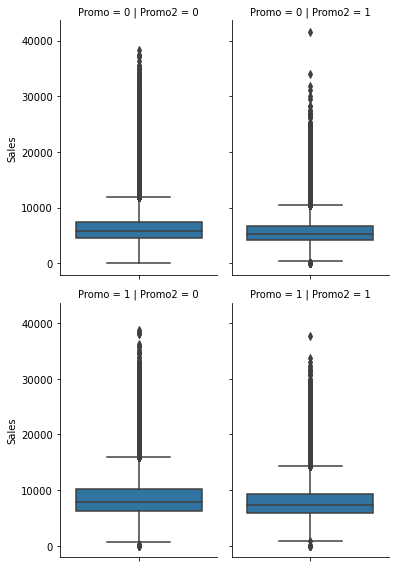

In [600]:
sns.catplot(y='Sales', data=df2, kind='box',
            col='Promo2', row='Promo', height=4, aspect=.7)

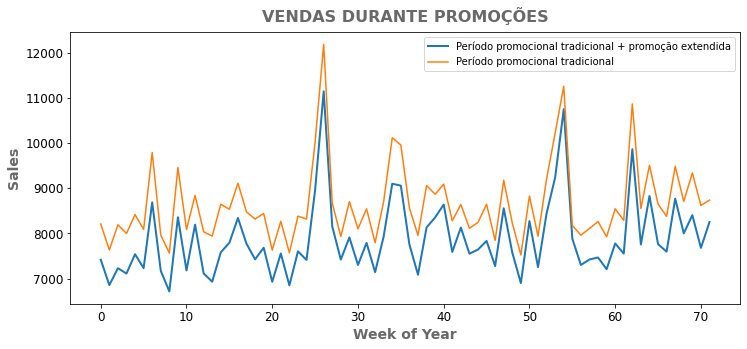

In [604]:
# Comportamento das vendas quando a loja participa da promoção e da promoção extendida.

# Vendas médias por semana para as lojas que estavam realizando promoções simultâneas nos dois tipos ('Promo' e 'Promo2') e agrupando por semana.
promo_1_2 = df2[(df2['Promo'] == 1) & (df2['Promo2'] == 1)][[
    'YearWeek', 'Sales']].groupby('YearWeek').mean().reset_index()
ax = promo_1_2.plot(fontsize=12, linewidth=2)

# Média de vendas para cada semana do ano em que a loja estava realizando uma promoção, mas não uma promoção contínua.
promo_1 = df2[(df2['Promo'] == 1) & (df2['Promo2'] == 0)][[
    'YearWeek', 'Sales']].groupby('YearWeek').mean().reset_index()
promo_1.plot(ax=ax)

ax.legend(labels=['Período promocional tradicional + promoção extendida',
          'Período promocional tradicional', 'Período promocional extendido'])
ax.set_title('VENDAS DURANTE PROMOÇÕES', pad=10,
             fontsize=16, color='dimgrey', fontweight='bold')
ax.set_xlabel('Week of Year', fontsize=14, color='dimgrey', fontweight='bold')
ax.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold');

## Hipóteses sobre temporalidade

### Lojas abertas durante o feriado de Natal vendem mais

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


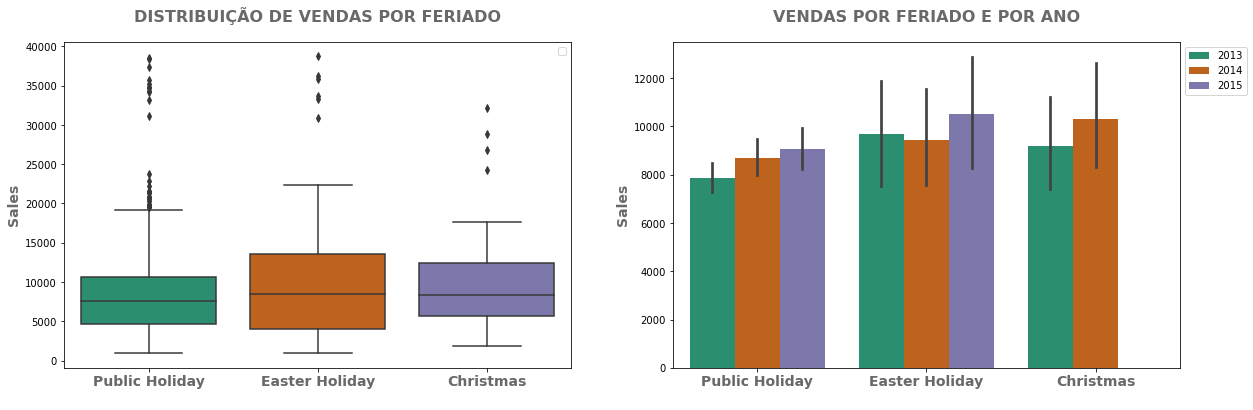

In [605]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Gráfico de Boxplot
sns.boxplot(x='StateHoliday', y='Sales', data=holidays,
            palette='Dark2', ax=ax0)
ax0.set_xticklabels(
    ['Public Holiday', 'Easter Holiday', 'Christmas'], fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_title('DISTRIBUIÇÃO DE VENDAS POR FERIADO', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')
ax0.legend()
ax0.set_xlabel(' ')
ax0.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')

# Gráfico de barras
sns.barplot(x='StateHoliday', y='Sales', hue='Year',
            palette='Dark2', data=holidays, ax=ax1)
ax1.set_title('VENDAS POR FERIADO E POR ANO', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')
ax1.set_xticklabels(
    ['Public Holiday', 'Easter Holiday', 'Christmas'], fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_xlabel(' ')
ax1.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
ax1.legend(bbox_to_anchor=(1, 1), loc=2)

### Lojas vendem menos durante os feriados escolares

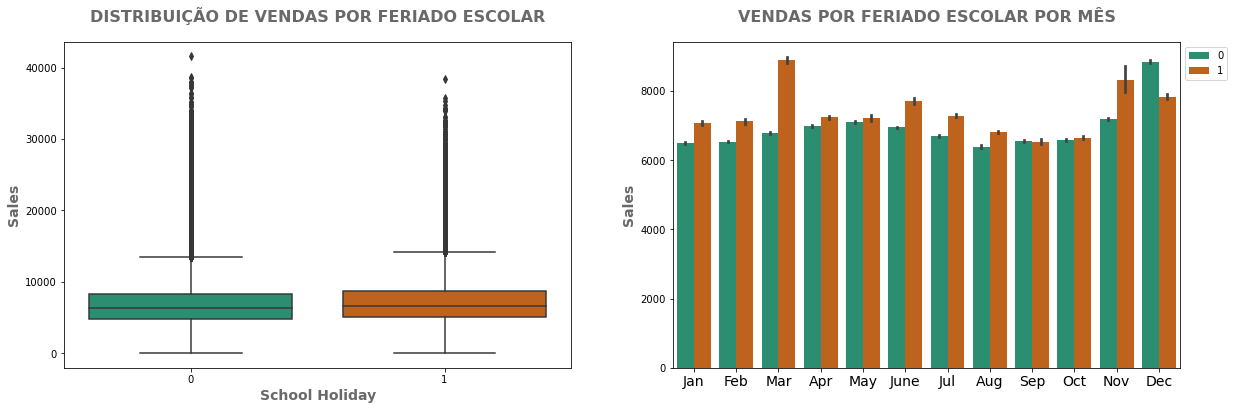

In [607]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

# Boxplot
sns.boxplot(x='SchoolHoliday', y='Sales', data=df2,
            palette='Dark2', ax=ax0)
ax0.set_xlabel('School Holiday', fontsize=14,
               color='dimgrey', fontweight='bold')
ax0.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_title('DISTRIBUIÇÃO DE VENDAS POR FERIADO ESCOLAR', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')
# Barplot
sns.barplot(x='Month', y='Sales', hue='SchoolHoliday',
            palette='Dark2', data=df2, ax=ax1)
ax1.set_xticklabels(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax1.set_xlabel(' ')
ax1.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_title('VENDAS POR FERIADO ESCOLAR POR MÊS', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')
ax1.legend(bbox_to_anchor=(1, 1), loc=2);

### Lojas vendem menos aos finais de semana

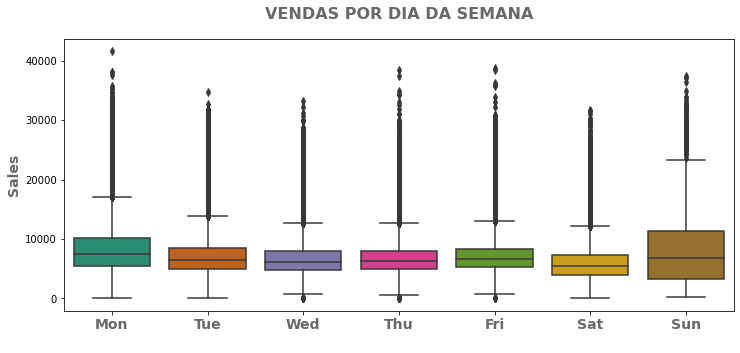

In [608]:
# Barplot
day_week = sns.boxplot(x='DayOfWeek', y='Sales', palette='Dark2', data=df2)
day_week.set_xticklabels(
    ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=14, color='dimgrey', fontweight='bold')
day_week.set_xlabel(' ')
day_week.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
day_week.set_title('VENDAS POR DIA DA SEMANA', pad=20,
                   fontsize=16, color='dimgrey', fontweight='bold');

###  Estação do ano
    As vendas podem ser influenciadas por mudanças sazonais, como o aumento das vendas de protetor solar no verão 
    ou de vitaminas e remédios no inverno.

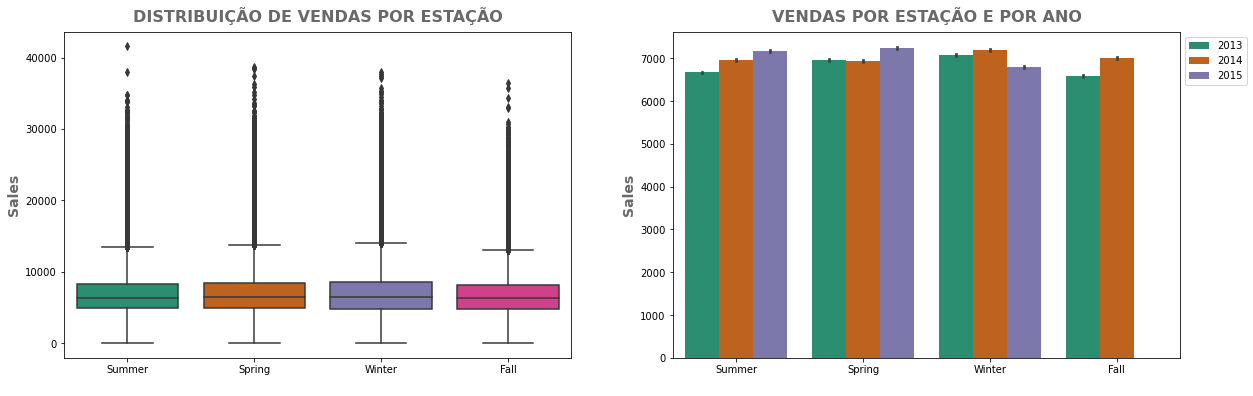

In [609]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

# Barplot
sns.boxplot(x='Season', y='Sales', palette='Dark2', data=df2, ax=ax0)
ax0.set_xlabel(' ')
ax0.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_title('DISTRIBUIÇÃO DE VENDAS POR ESTAÇÃO', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')

# Barplot
sns.barplot(x='Season', y='Sales', hue='Year',
            palette='Dark2', data=df2, ax=ax1)
ax1.set_xlabel(' ')
ax1.set_ylabel('Sales', fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_title('VENDAS POR ESTAÇÃO E POR ANO', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')
ax1.legend(bbox_to_anchor=(1, 1), loc=2);

## Análise Multivariada

In [610]:
df_corr = df2.corr()

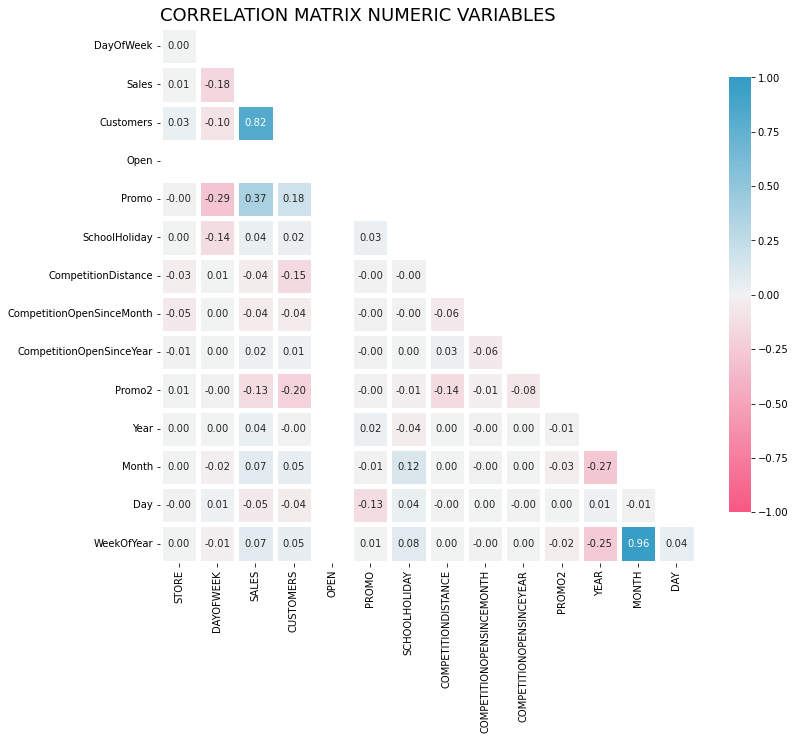

In [611]:
fig, ax = plt.subplots(figsize=(12, 10))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:, :-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
           linewidths=5, cmap=cmap, vmin=-1, vmax=1,
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX NUMERIC VARIABLES'
plt.title(title, loc='left', fontsize=18);

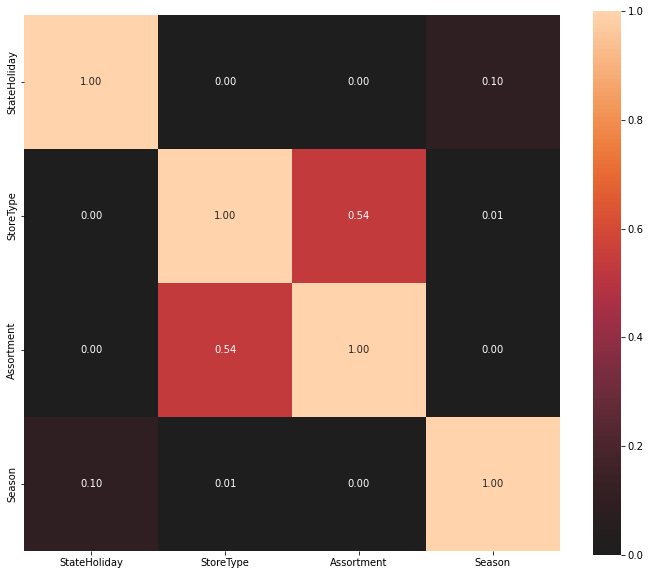

{'corr':               StateHoliday  StoreType  Assortment  Season
 StateHoliday          1.00       0.00        0.00    0.10
 StoreType             0.00       1.00        0.54    0.01
 Assortment            0.00       0.54        1.00    0.00
 Season                0.10       0.01        0.00    1.00,
 'ax': <AxesSubplot:>}

In [612]:
categorical = df1[['StateHoliday', 'StoreType', 'Assortment', 'Season']]
# Calculate Cramer V
associations(categorical, figsize=(12,10))

# SPLIT

In [613]:
df3 = df2.copy()

In [614]:
# Verificar data do primeiro dia das últimas 6 semanas: 42 dias
df3[['Store', 'Date']].groupby('Store').max().reset_index()['Date'][0] - datetime.timedelta(days = 6 * 7)

Timestamp('2015-06-19 00:00:00')

In [615]:
# Training Dataset
X_train = df3[df3['Date'] < '2015-06-19']
y_train = X_train['Sales']

# Teste Dataset
X_test = df3[df3['Date'] >= '2015-06-19']
y_test = X_test['Sales']

In [616]:
# Verificação da separação
print(f"Train Min Date: {X_train['Date'].min()}")
print(f"Train Max Date: {X_train['Date'].max()}")

print(f"\nTest Min Date: {X_test['Date'].min()}")
print(f"Test Max Date: {X_test['Date'].max()}")

Train Min Date: 2013-01-01 00:00:00
Train Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00
